**Preliminary ANN for quantity estimation**

Author - Ananya Jain (Computation Cognitive Neuroscience Lab)

In [ ]:
pip install tensorflow

Task - **Dots estimation**
1. To define a shallow CNN (with 3-5 layers) where the last layer is a single unit.
2. Create stimuli between 50 and 200 black dots on a white background.
3. Error = sqared difference between the networks guess and that true number of dots


<ipython-input-9-6f3a88de5194>:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Number of Dots: {int(Y[0])}')


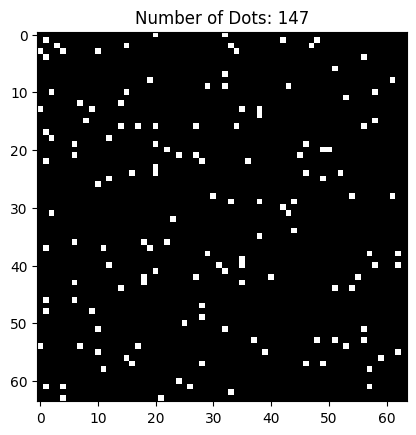

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

def generate_data(num_samples, img_size=64, min_dots=50, max_dots=200):
    # numpy is used for array manipulation
    # generate X with num_samples elements each of size (img_size * img_size). Instantiates this to zero
    # generate Y with num_samples elements each of size 1 and isntantiate them to zero.
    X = np.zeros((num_samples, img_size, img_size))
    Y = np.zeros((num_samples, 1))
    # specify dots and classes
    # 3 classes - 10, 20, 30 labels as 1, 2, 3 - specify labels beforehand

    for i in range(num_samples):

        # randomly generating number of dots between 50 and 201 exclusive
        num_dots = np.random.randint(min_dots, max_dots + 1)
        Y[i] = num_dots

        for _ in range(num_dots):
            x, y = np.random.randint(0, img_size, 2)
            X[i, x, y] = 1

    return X, Y

# Generate data set for the CNN
X, Y = generate_data(5000)

# Visualize an example using matplotlib
plt.imshow(X[0], cmap='gray')
plt.title(f'Number of Dots: {int(Y[0])}')
plt.show()

Now we need to split the data that was generated into training and validation sets
* Normalize the data
* reshape X into a **4-dimensional space** because this is the format that neural networks in Tensorflow expect input
* first value is number of samples, the second and third are the dimensions of the image, and fourth indicates greyscale
* dividing by 255 helps **scale the pixel values** to speed up the training process.
* Neural networks (especially gradient descent-based optimizations) work better on input on a smaller scale
* we then split the data into train and validation sets to be fed into the network

In [ ]:
X = X.reshape(-1, 64, 64, 1) / 255.0

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(4000, 64, 64, 1)
(4000, 1)
(1000, 64, 64, 1)
(1000, 1)


Building a **shallow Convolutional Neural Network** model using Keras.



* sequential() arranges the layers of the neural network in a sequence, where the layer recieves information only from the previous layers.
* first convolutional layer takes in **32 kernels** for feature extraction, where each kernel is 3x3 pixels.
* Patterns could be complex so our model relies on activation = 'relu' which is the **Rectified Linear unit activation** to introduce non-linearity into our model
* first pooling layer -this reduces the spatial dimensions of the previous layer from 3x3 to 2x2.
* second convulational layer - this has **64 kernels**, to learn more complex patterns
* second pooling layer also reduces the spatial dimensions
* Flattening layer - flattens the output of the pooling layer into a 1D array to be fed into the dense layer
* first dense layer - this layer has 64 neurons and performs further processing on the flattened input
* output layer - this returns a single neuron. Since we are doing an **regression task for estimation**, the output is only in the form of one neuron to provide the estimated number of dots.

The next step is to **compile the model**

* we compile the model and make it ready for training.
* Use the **stochastic gradient descent** optimization algorithm Adam since it needs little manual tuning of the learning rate. Stochastic gradient descent is an algorithm that is used to minimize some function, in this case it is the loss function. In a stochastic model the gradient of loss function is calculated primarily over a small suset of the data. This tends tohave higher convergence.
* the loss/error is the **mean squared error**. It calculates the average of the squared differnces between the predicted values and the actual values to measure the quality of the model's prediction.


In [ ]:
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1), padding='same'),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Dropout(0.25),

#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     MaxPooling2D(2, 2),
#     Dropout(0.25),

#     Flatten(),
#     Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
#     Dropout(0.5),
#     Dense(1, activation='linear')  # Output layer for regression
# ])
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    MaxPooling2D(2, 2),
    # Dropout(0.25),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Dropout(0.25),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)) ,
    # Dropout(0.5),
    Dense(1)  # Output layer for regression
])
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
#     MaxPooling2D(2, 2),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D(2, 2),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1)  # Output layer for regression
# ])

model.compile(optimizer='adam', loss='mean_squared_error')

**Training the model** on the dataset

Training is the proscess of finding the best weights and biases for all the neurons such that the neural network can correctly map inputs to the desired output.


* model.fit() means training the model (CNN with muliple layers that we defined above) with the data set
* X_train, Y_train are the splits of the dataset we created above with X as our images and Y having the number of dots
* epochs is the number of times the training dataset wul be passed forward and backward through the neural network.
* after each epoch of training, the validation data is used to monitor the model's performance and check for overfitting
* **Overfitting** occurs when the model performs well on training data but not unseen data, we need to avoid for that to happen.


During training the main thing that happens is that the data is processed in small batches during the epochs and the network calculates the loss between the actual and predicted values and then **updates the weights in a way that would minimize the loss**. This optimization in our case is done using the Adam optimizer.

**History can be used to plot the training and validation** loss over epochs to diagnose issues like overfitting or underfitting.

Result of traning is that he model has learnt to estimate the number of dots. Accuracy and reliability depepnd o complexity of the model, quality and quantity of the data, and the training duration.

In [ ]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, Y_train, batch_size = 30, epochs=30, validation_data=(X_val, Y_val))
# callbacks=[early_stopping]

Epoch 1/30
134/134 [==============================] - 10s 77ms/step - loss: 36.9568 - val_loss: 36.9734
Epoch 2/30
134/134 [==============================] - 9s 68ms/step - loss: 34.2518 - val_loss: 38.9357
Epoch 3/30
134/134 [==============================] - 10s 76ms/step - loss: 35.6406 - val_loss: 32.4333
Epoch 4/30
134/134 [==============================] - 10s 76ms/step - loss: 34.7029 - val_loss: 97.2058
Epoch 5/30
134/134 [==============================] - 10s 76ms/step - loss: 39.6678 - val_loss: 100.8336
Epoch 6/30
134/134 [==============================] - 10s 73ms/step - loss: 39.6800 - val_loss: 31.8954
Epoch 7/30
134/134 [==============================] - 10s 71ms/step - loss: 33.7907 - val_loss: 57.4262
Epoch 8/30
134/134 [==============================] - 10s 76ms/step - loss: 33.4319 - val_loss: 38.4638
Epoch 9/30
134/134 [==============================] - 10s 76ms/step - loss: 34.9601 - val_loss: 31.1217
Epoch 10/30
134/134 [==============================] - 10s 76ms/

32/32 [==============================] - 1s 24ms/step


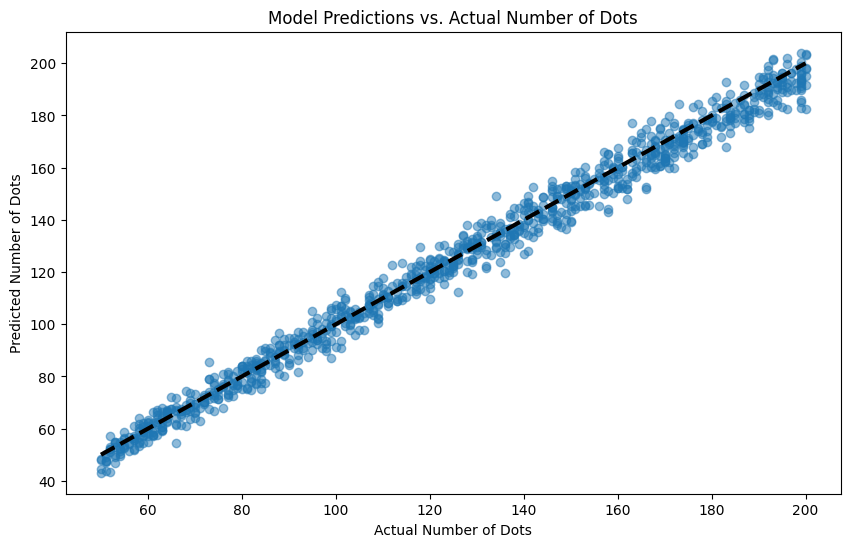

In [ ]:


# Make predictions on the validation set
predictions = model.predict(X_val).flatten()

# Plotting the model's guesses against the actual number of dots
plt.figure(figsize=(10, 6))
plt.scatter(Y_val, predictions, alpha=0.5)
plt.plot([Y_val.min(), Y_val.max()], [Y_val.min(), Y_val.max()], 'k--', lw=3)
plt.xlabel('Actual Number of Dots')
plt.ylabel('Predicted Number of Dots')
plt.title('Model Predictions vs. Actual Number of Dots')
plt.show()


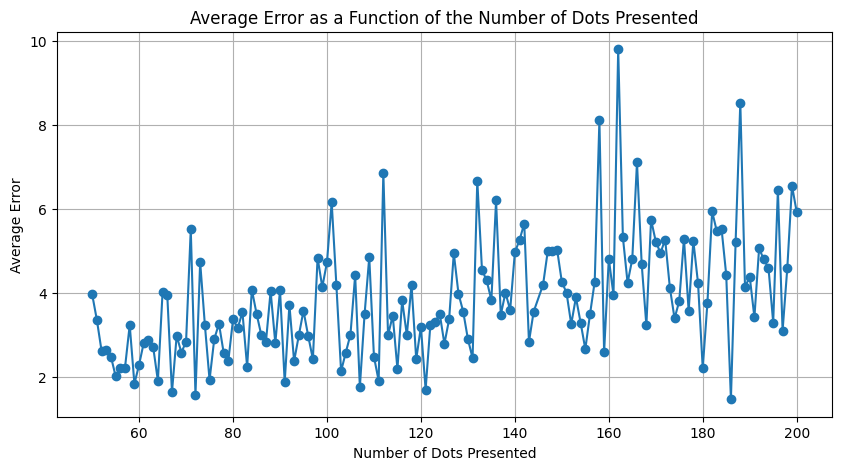

In [ ]:

# Calculating absolute errors
import numpy as np
errors = np.abs(predictions - Y_val.flatten())

# Group errors by the actual number of dots presented
error_dict = {}
for actual, error in zip(Y_val.flatten(), errors):
    if actual not in error_dict:
        error_dict[actual] = []
    error_dict[actual].append(error)

# Calculate the average error for each number of dots
average_errors = {k: np.mean(v) for k, v in error_dict.items()}

# Sort the dictionary by key (number of dots) to plot
sorted_dots = sorted(average_errors.keys())
sorted_errors = [average_errors[k] for k in sorted_dots]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sorted_dots, sorted_errors, marker='o')
plt.xlabel('Number of Dots Presented')
plt.ylabel('Average Error')
plt.title('Average Error as a Function of the Number of Dots Presented')
plt.grid(True)
plt.show()

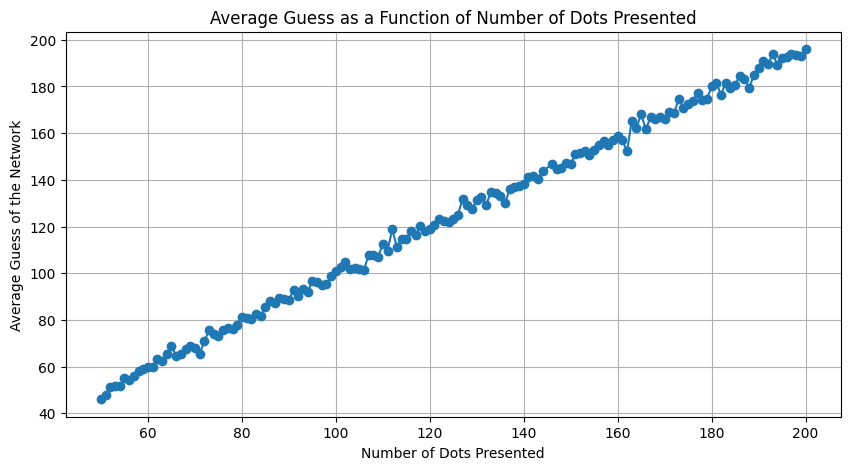

In [ ]:
prediction_dict = {}
for real, pred in zip(Y_val.flatten(), predictions):
    if real not in prediction_dict:
        prediction_dict[real] = []
    prediction_dict[real].append(pred)

# Calculate the average prediction for each number of dots
average_predictions = {k: np.mean(v) for k, v in prediction_dict.items()}

# Sort the dictionary by key (number of dots) to plot
sorted_dots = sorted(average_predictions.keys())
sorted_avg_predictions = [average_predictions[k] for k in sorted_dots]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sorted_dots, sorted_avg_predictions, marker='o')
plt.xlabel('Number of Dots Presented')
plt.ylabel('Average Guess of the Network')
plt.title('Average Guess as a Function of Number of Dots Presented')
plt.grid(True)
plt.show()

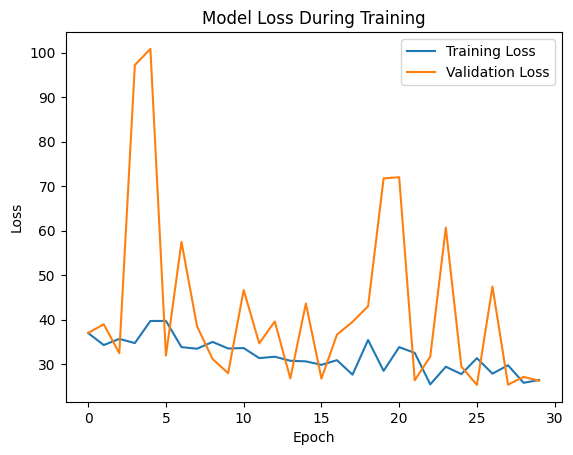

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
final_loss = model.evaluate(X_val, Y_val)
print(f"Final Loss on Validation Set: {final_loss}")
print("model is off by ", final_loss ** 0.5, "dots")

32/32 [==============================] - 1s 20ms/step - loss: 26.2322
Final Loss on Validation Set: 26.232175827026367
model is off by  5.121735626428444 dots
